DATA LOADING


In [1]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/FINAL_PROJECT/DATASET/stock_yfinance_data.csv'
all_tweets = pd.read_csv(path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
## import data
# df = pd.read_csv('DATA.csv', parse_dates=['Date'])
print(all_tweets.head())
print(all_tweets.tail())
print(all_tweets.shape)
print(all_tweets.columns)

         Date        Open        High         Low       Close   Adj Close  \
0  2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1  2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2  2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3  2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4  2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   

     Volume Stock Name  
0  53868000       TSLA  
1  51094200       TSLA  
2  91449900       TSLA  
3  55297800       TSLA  
4  43898400       TSLA  
            Date   Open    High    Low  Close  Adj Close    Volume Stock Name
6295  2022-09-23  13.09  13.892  12.86  13.71      13.71  28279600       XPEV
6296  2022-09-26  14.28  14.830  14.07  14.37      14.37  27891300       XPEV
6297  2022-09-27  14.58  14.800  13.58  13.71      13.71  21160800       XPEV
6298  2022-09-28  13.05  13.421  12.69  13.33      13.33  31799400       XP

In [4]:
#stock_name = 'GOOG'

stock_name = input("Enter stock name - ")
df = all_tweets[all_tweets['Stock Name'] == stock_name]
#dataset = dataset[dataset['Stock Name'] == stock_name]


Enter stock name - AMZN


In [5]:
print(df.shape)
df.head()

(252, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
1008,2021-09-30,165.800003,166.392502,163.699493,164.251999,164.251999,56848000,AMZN
1009,2021-10-01,164.450500,165.458496,162.796997,164.162994,164.162994,56712000,AMZN
1010,2021-10-04,163.969498,163.999496,158.812500,159.488998,159.488998,90462000,AMZN
1011,2021-10-05,160.225006,163.036499,160.123001,161.050003,161.050003,65384000,AMZN
1012,2021-10-06,160.676498,163.216995,159.931000,163.100494,163.100494,50660000,AMZN


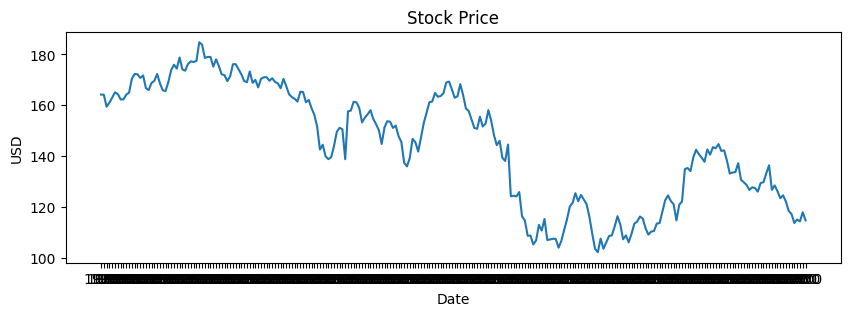

In [6]:
# Create stock price plot
## https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df['Date'], df['Close'], label='Stock Price')
ax.set(xlabel="Date",
       ylabel="USD",
       title="Stock Price")
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
plt.show()

In [7]:
# Calculate technical indicators
def get_technical_indicators(data):
    # Create 7 and 21 days Moving Average
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean()
    data['MA21'] = data.iloc[:,4].rolling(window=21).mean()

    # Create MACD
    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA21'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA21'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data
T_df = get_technical_indicators(df)

<ipython-input-7-03c50a47f6f1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA7'] = data.iloc[:,4].rolling(window=7).mean()
<ipython-input-7-03c50a47f6f1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA21'] = data.iloc[:,4].rolling(window=21).mean()
<ipython-input-7-03c50a47f6f1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [8]:
#Drop the first 21 rows
#For doing the fourier
dataset = T_df.iloc[20:,:].reset_index(drop=True)

In [9]:
#Getting the Fourier transform features
def get_fourier_transfer(dataset):
    # Get the columns for doing fourier
    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_com_df = pd.DataFrame()
    for num_ in [3, 6, 9]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        fft_ = np.fft.ifft(fft_list_m10)
        fft_com = pd.DataFrame({'fft': fft_})
        fft_com['absolute of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.abs(x))
        fft_com['angle of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.angle(x))
        fft_com = fft_com.drop(columns='fft')
        fft_com_df = pd.concat([fft_com_df, fft_com], axis=1)

    return fft_com_df

In [10]:
#Get Fourier features
dataset_F = get_fourier_transfer(dataset)
Final_data = pd.concat([dataset, dataset_F], axis=1)


print(Final_data.head())

         Date        Open        High         Low       Close   Adj Close  \
0  2021-10-28  170.104996  173.949997  169.300003  172.328506  172.328506   
1  2021-10-29  165.001007  168.740997  163.666000  168.621506  168.621506   
2  2021-11-01  168.089996  168.792999  164.600998  165.905502  165.905502   
3  2021-11-02  165.750504  166.556000  164.177505  165.637497  165.637497   
4  2021-11-03  165.449997  169.746002  164.876007  169.199997  169.199997   

      Volume Stock Name         MA7        MA21  ...  upper_band  lower_band  \
0  114174000       AMZN  169.436571  166.502239  ...  174.724811  158.279667   
1  129722000       AMZN  169.132071  166.710310  ...  174.894671  158.525950   
2   72178000       AMZN  168.297071  166.793287  ...  174.234002  159.352572   
3   52552000       AMZN  168.134214  167.086073  ...  173.997963  160.174182   
4   67944000       AMZN  168.588715  167.474168  ...  174.122785  160.825550   

          EMA  logmomentum  absolute of 3 comp  angle of

In [11]:
Final_data.to_csv("/content/drive/MyDrive/FINAL_PROJECT/PROJECT/AMAZON/Finaldata_with_Fourier.csv", index=False)

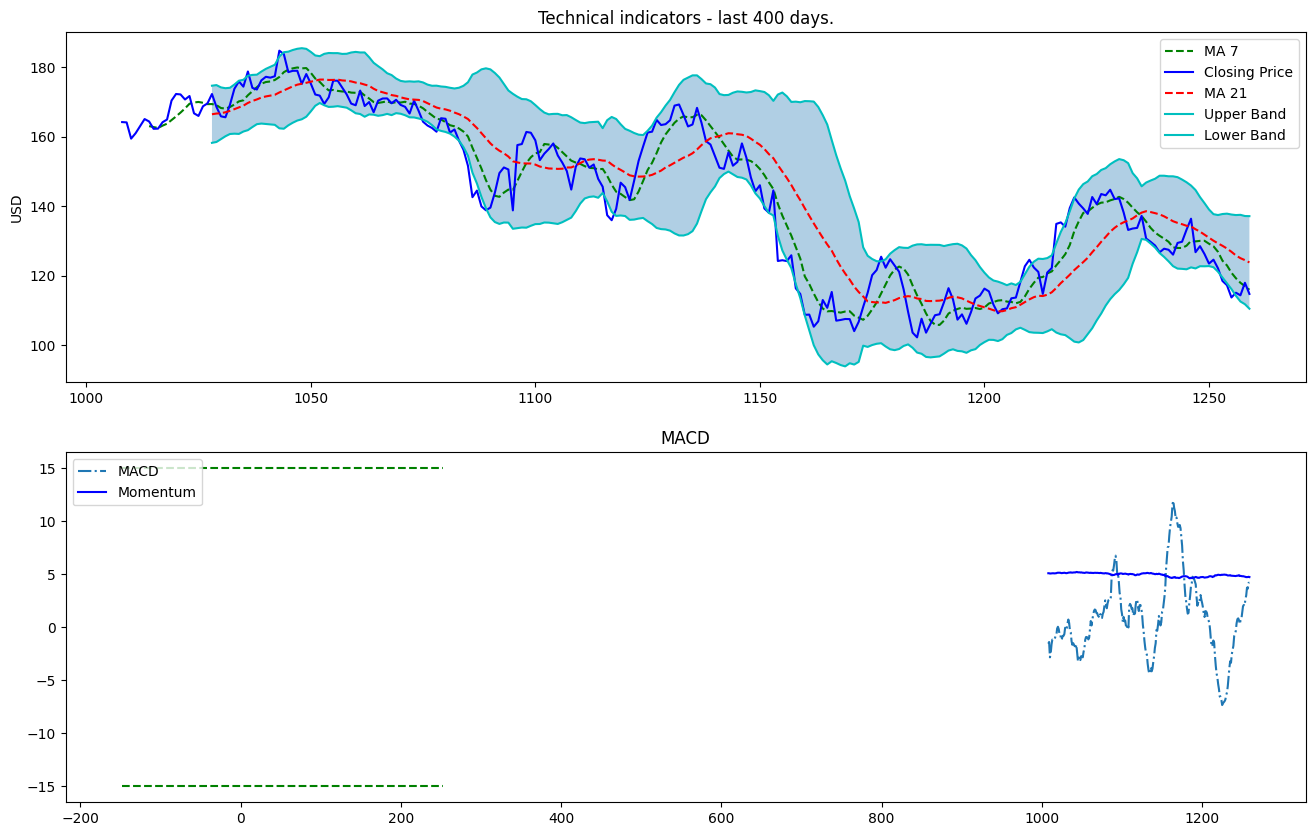

In [12]:
def plot_technical_indicators(dataset, last_days):
       plt.figure(figsize=(16, 10), dpi=100)
       shape_0 = dataset.shape[0]
       xmacd_ = shape_0 - last_days

       dataset = dataset.iloc[-last_days:, :]
       x_ = range(3, dataset.shape[0])
       x_ = list(dataset.index)

       # Plot first subplot
       plt.subplot(2, 1, 1)
       plt.plot(dataset['MA7'], label='MA 7', color='g', linestyle='--')
       plt.plot(dataset['Close'], label='Closing Price', color='b')
       plt.plot(dataset['MA21'], label='MA 21', color='r', linestyle='--')
       plt.plot(dataset['upper_band'], label='Upper Band', color='c')
       plt.plot(dataset['lower_band'], label='Lower Band', color='c')
       plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
       plt.title('Technical indicators - last {} days.'.format(last_days))
       plt.ylabel('USD')
       plt.legend()

       # Plot second subplot
       plt.subplot(2, 1, 2)
       plt.title('MACD')
       plt.plot(dataset['MACD'], label='MACD', linestyle='-.')
       plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
       plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
       plt.plot(dataset['logmomentum'], label='Momentum', color='b', linestyle='-')

       plt.legend()
       plt.show()

plot_technical_indicators(T_df, 400)

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


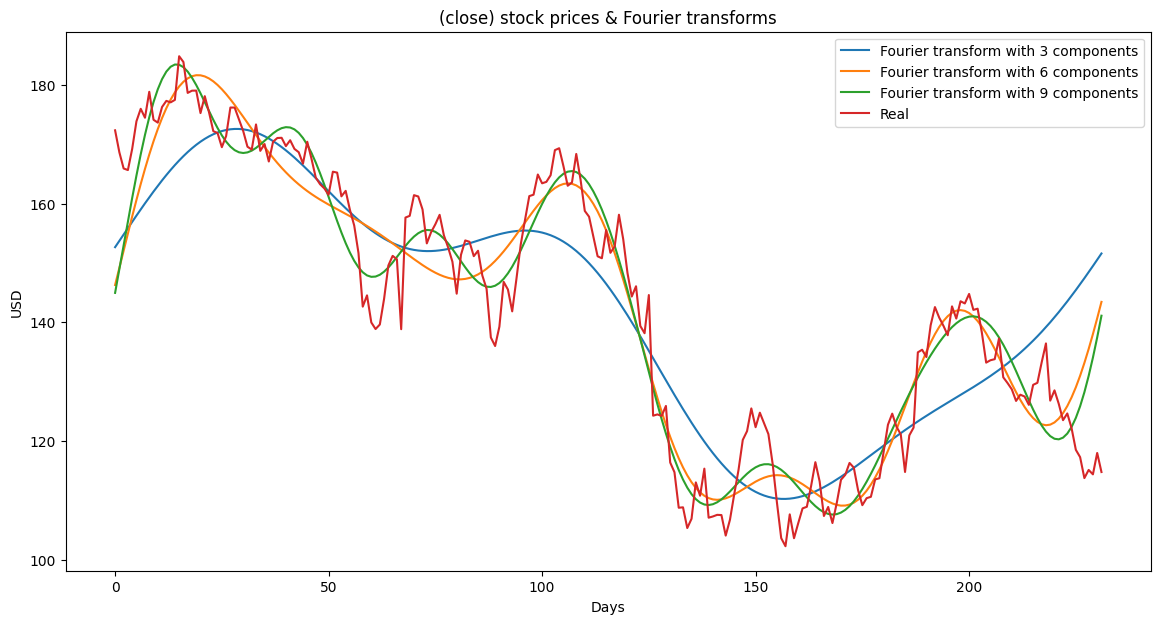

In [13]:
def plot_Fourier(dataset):
    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    plt.figure(figsize=(14, 7), dpi=100)
    fft_list = np.asarray(fft_df['fft'].tolist())
    for num_ in [3, 6, 9]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
    plt.plot(data_FT['Close'], label='Real')
    plt.xlabel('Days')
    plt.ylabel('USD')
    plt.title('(close) stock prices & Fourier transforms')
    plt.legend()
    plt.show()

plot_Fourier(dataset)